In [16]:
import os
import sys
from datetime import datetime
from os.path import abspath
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs
from hurst import compute_Hc

yf.pdr_override()

# Zipline imports
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar

from zipline.api import set_max_leverage, schedule_function, set_benchmark,set_commission
from zipline.finance.commission import PerContract, PerDollar, PerShare, PerTrade
from zipline.finance.commission import CommissionModel
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.api import set_slippage, set_commission
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.api import (order, 
                         order_target,
                         order_value,
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol # type: ignore

# Ignore Warnings  
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
%load_ext autoreload
%autoreload 2

ROOT_DIR = abspath('../')
sys.path.append(ROOT_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
bundle = 'sp50bundle'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
sp50tickers = [coin.symbol for coin in assets]

In [18]:
len(sp50tickers)

50

In [19]:
def calculate_bollinger_bands(prices, dev, window=20):
    sma = prices.mean()
    rolling_std = prices.std()
    upper_band = sma + (dev * rolling_std)
    lower_band = sma - (dev * rolling_std)
    return upper_band, sma, lower_band

def calculate_rsi(prices, window):
    deltas = [prices[i + 1] - prices[i] for i in range(len(prices) - 1)]
    gains = [delta if delta > 0 else 0 for delta in deltas]
    losses = [-delta if delta < 0 else 0 for delta in deltas]

    avg_gain = sum(gains[:window]) / window
    avg_loss = sum(losses[:window]) / window

    rs = avg_gain / avg_loss if avg_loss != 0 else float('inf')
    rsi = 100 - (100 / (1 + rs))

    for i in range(window, len(prices) - 1):
        delta = prices[i + 1] - prices[i]
        gain = delta if delta > 0 else 0
        loss = -delta if delta < 0 else 0

        avg_gain = ((avg_gain * (window - 1)) + gain) / window
        avg_loss = ((avg_loss * (window - 1)) + loss) / window

        rs = avg_gain / avg_loss if avg_loss != 0 else float('inf')
        rsi.append(100 - (100 / (1 + rs)))

    return rsi

    
def calculate_atr(high_prices, low_prices, close_prices, period=14):
    high_low_diff = high_prices - low_prices
    high_close_diff = np.abs(high_prices - np.roll(close_prices, 1))
    low_close_diff = np.abs(low_prices - np.roll(close_prices, 1))
    true_range = np.maximum(high_low_diff, high_close_diff, low_close_diff)
    atr = np.mean(true_range[:period])
    for i in range(period, len(true_range)):
        atr = ((period - 1) * atr + true_range[i]) / period
    return atr

def plots(results):
    start = results.index[0]
    end = results.index[-1]
    benchmark = pdr.get_data_yahoo('^GSPC', start=start, end=end)['Adj Close'].pct_change()
    results.index = pd.to_datetime(results.index).tz_convert(None)
    results.index = benchmark.index  
    qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df=results)  
    


In [20]:
START_DATE = pd.Timestamp('2018-01-01')
END_DATE = pd.Timestamp('2022-12-31') # Backtesting for 5 years

BASE_CAPITAL = 100_000

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-02-05   2018-02-05
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          39.01%       79.5%
Mean Active Return         0.0%         0.02%
CAGR﹪                     4.75%        8.59%

Sharpe                     0.42         0.65
Prob. Sharpe Ratio         81.95%       92.15%
Smart Sharpe               0.38         0.59
Sortino                    0.57         0.92
Smart Sortino              0.52         0.84
Sortino/√2                 0.41         0.65
Smart Sortino/√2           0.37         0.59
Omega                      1.14         1.14

Max Drawdown               -33.92%      -40.3%
Longest DD Days            361          352
Volatility (ann.)          22.01%       22.26%
R^2                        0.74         0.74
Calmar               

None

0.028569719903475017





,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-14,2020-03-23,2020-11-23,315,-40.302635,-35.740223
2,2022-03-30,2022-10-12,2022-12-30,276,-22.370170,-21.968410
3,2018-09-24,2018-12-24,2019-09-10,352,-20.045040,-16.424745
4,2022-02-03,2022-02-23,2022-03-28,54,-8.769083,-8.495758
5,2018-03-13,2018-03-28,2018-05-03,52,-7.627798,-7.323193


Average Long Exposure = 104622.57044400317
Average Short Exposure = -502.62158856235106
Average Net Leverage = 0.7390166571087625
Average Gross Leverage = 0.7478607896078643
Max Leverage = 1.1378415224766902



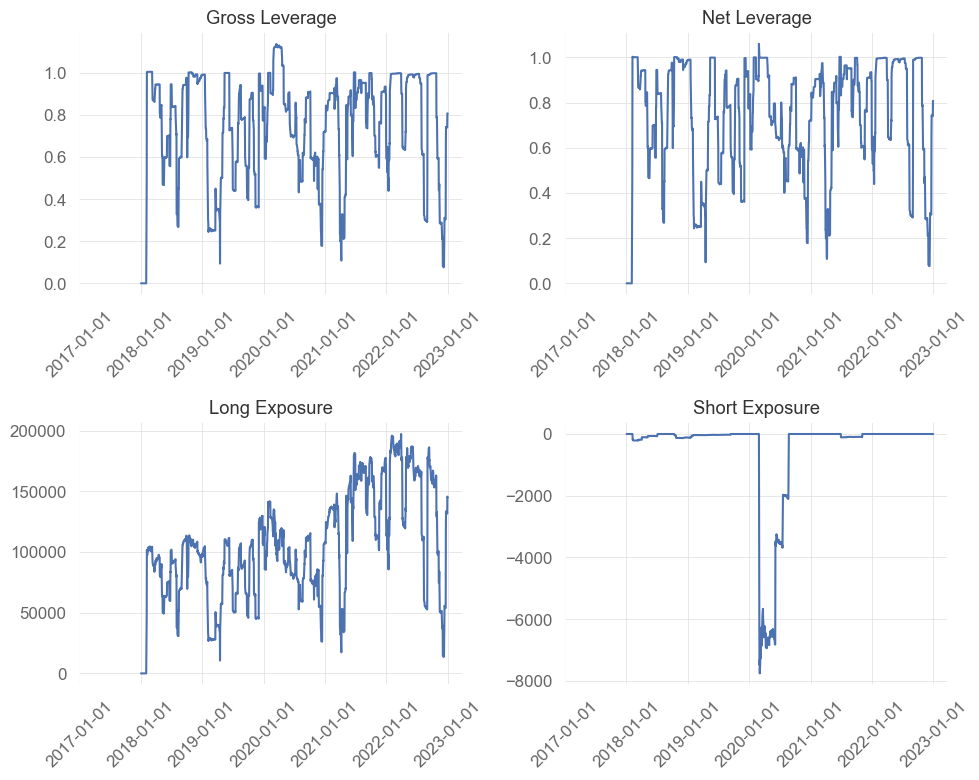

AAPL ABT ADBE AEP AES AFL ALGN AMD AMT AOS APA APD ARE AWK AXON BA BAC BAX BDX BG BKR BRK-B BX BXP CAT CCI CDNS CE COF CPB CPT DIS EA FMC FOX IFF KLAC LNT MMM MO NVDA STZ TECH TRGP VLO WBD WMB WMT


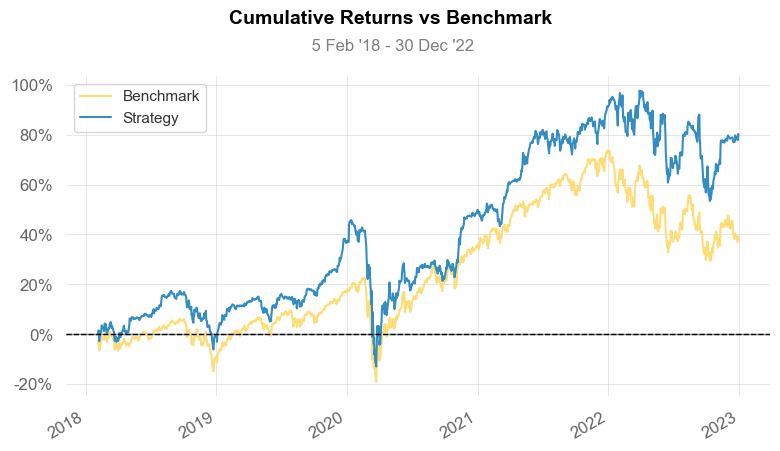

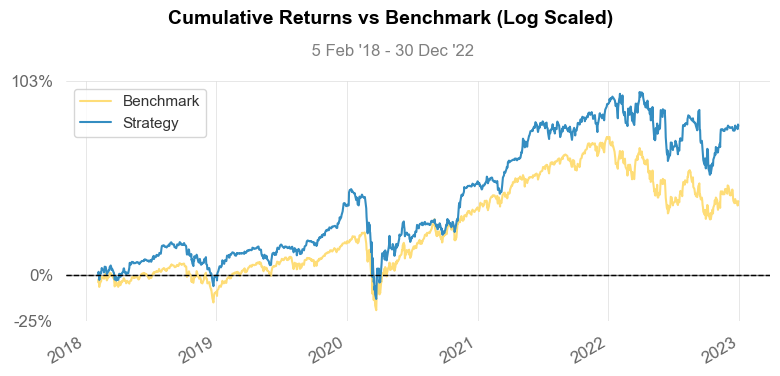

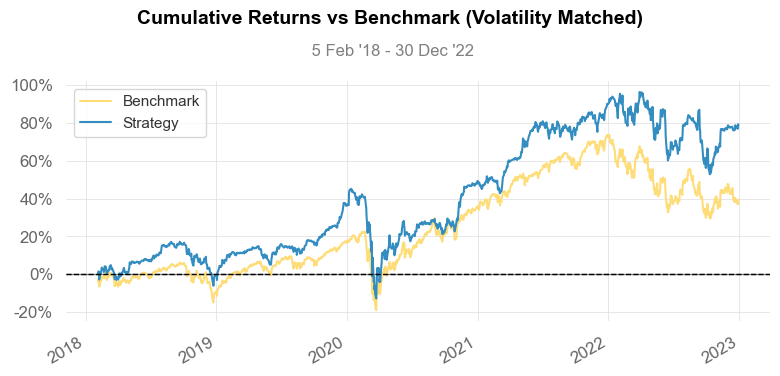

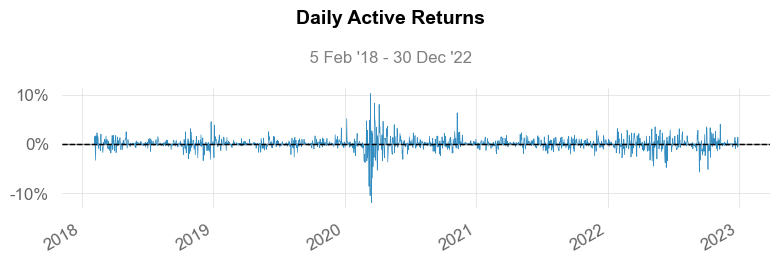

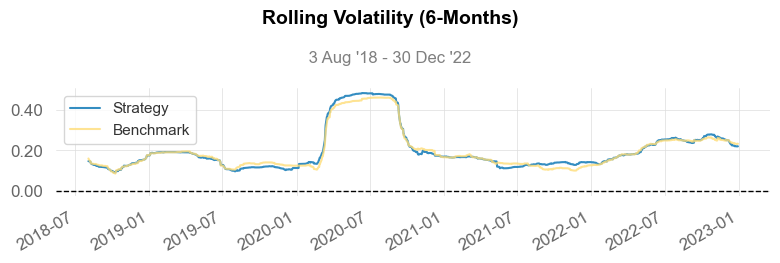

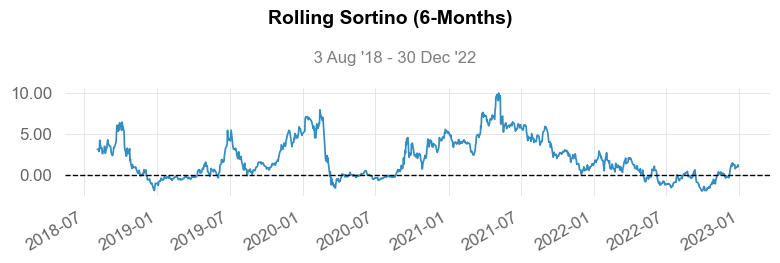

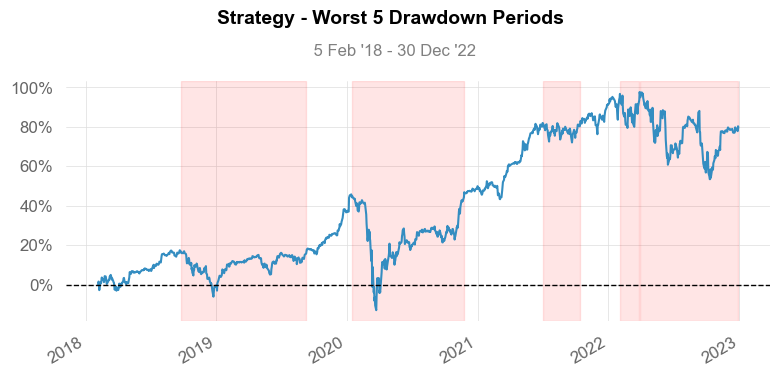

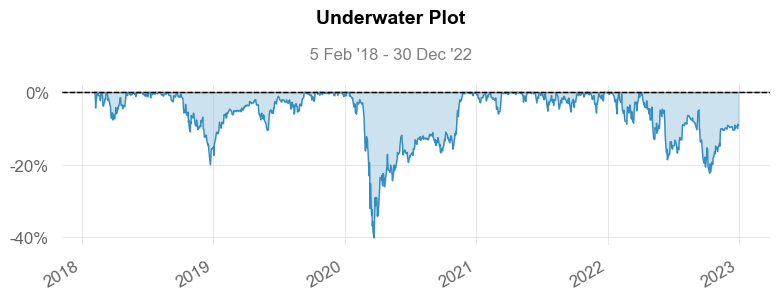

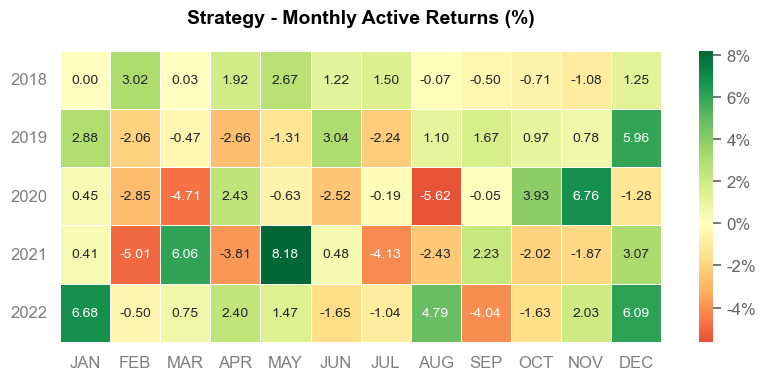

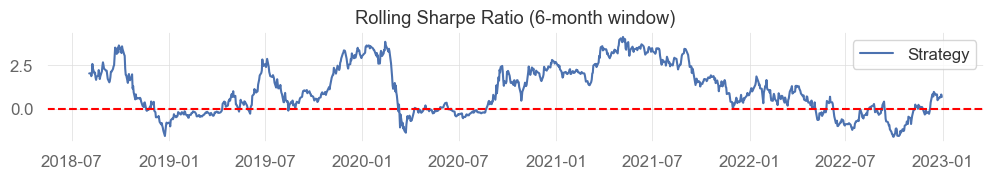

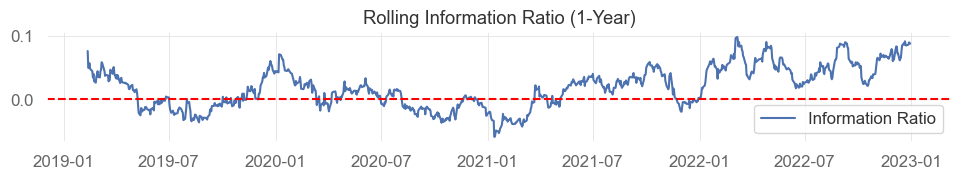

[*********************100%%**********************]  1 of 1 completed


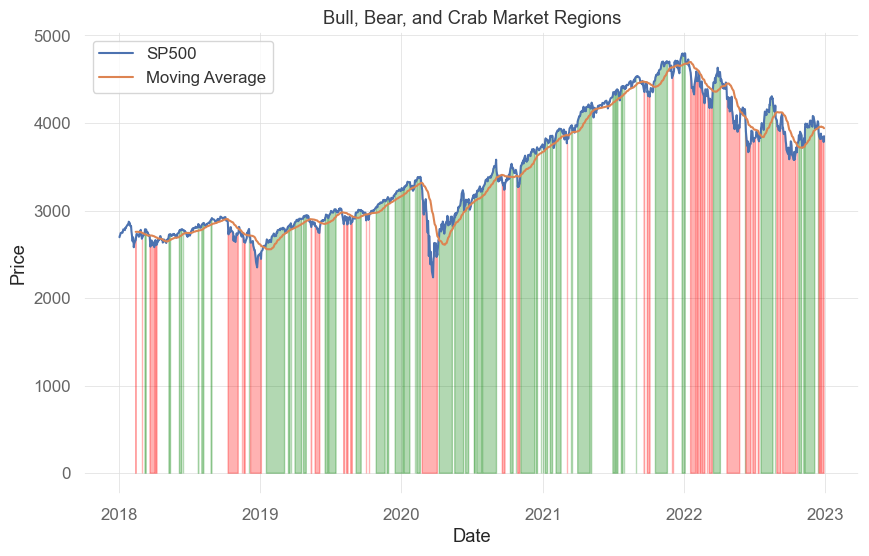

Total Trades: 451
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





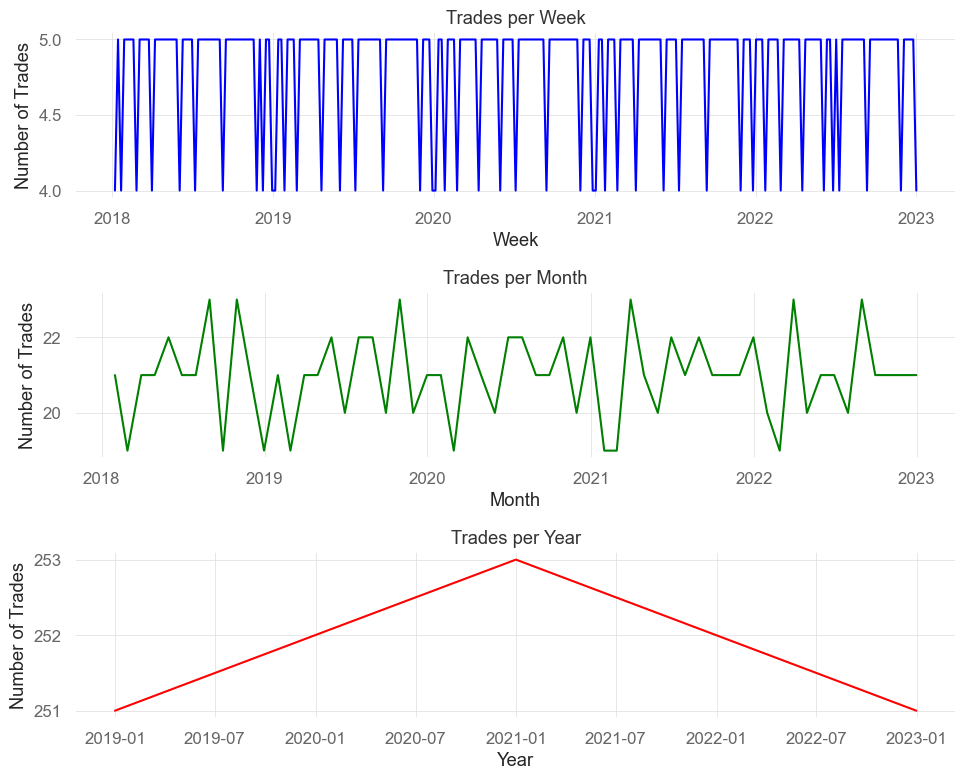

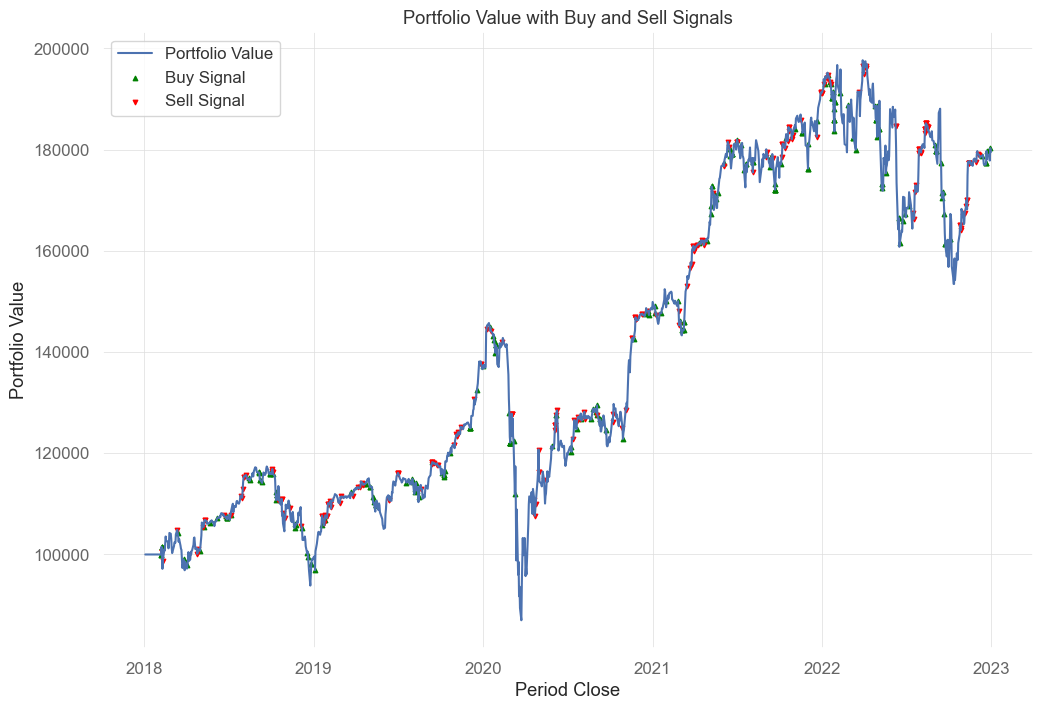

In [21]:
def initialize(context):
    context.idx = 0
    context.tickers = sp50tickers
    context.window = 20
    context.bollinger_dev = 1.5
    context.stop_loss = 0.05 
    context.take_profit  = 0.05
    context.stops, context.profits = 0, 0
    context.buy_stocks = set()
    context.cash_pct = 0.25
    context.atr_window = 14
    context.atr_dev = 1.5
    context.buy_count, context.sell_count = 0, 0
    context.current_date = None
    
    # set_commission(PerShare(cost=0.003))
    # set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))        
        
def handle_data(context, data):
    if context.idx < context.window:
            context.idx += 1
            return

    
    for ticker in context.tickers:
        # Get historical price data using data.history
        prices = data.history(symbol(ticker), 'price', context.window + 1, '1d')
    
        # Calculate Bollinger Bands
        upper_band, mid_band, lower_band = calculate_bollinger_bands(prices, context.bollinger_dev, window=context.window)
        rsi_value = calculate_rsi(prices,window=context.window)
        current_price = data.current(symbol(ticker), 'price')
        
        open_orders = get_open_orders(ticker)
        if ticker not in open_orders: 
        # Generate signals based on Bollinger Bands, 
            if current_price < lower_band and rsi_value<30 and ticker not in context.buy_stocks:       # 
                order_value(symbol(ticker), context.portfolio.cash * context.cash_pct)  # Buy Signal
                context.buy_count += 1
                context.buy_stocks.add(ticker)
                # print("Bought")
            elif current_price > upper_band and rsi_value>70 and ticker in context.buy_stocks: #
                order_target_percent(symbol(ticker), 0)  # Sell Signal
                context.sell_count += 1
                context.buy_stocks.remove(ticker)
                # print("Sold")
        
                
        # Record the values for later analysis
        record(
            price=current_price,
            mid=mid_band,
            upper=upper_band,
            lower=lower_band,
            rsi= rsi_value,
            buy_count = context.buy_count, 
            sell_count = context.sell_count, 
            profits = context.profits,
            stops = context.stops         
        )
        
# Run the algorithm
results = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=BASE_CAPITAL,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp50bundle',
)
plots(results)

In [22]:
def initialize(context):
    context.idx = 0
    context.tickers = sp50tickers
    context.window = 20
    context.bollinger_dev = 1.5
    context.stop_loss = 0.05 
    context.take_profit  = 0.05
    context.stops, context.profits = 0, 0
    context.buy_stocks = set()
    context.cash_pct = 0.25
    context.atr_window = 14
    context.atr_dev = 1.5
    context.buy_count, context.sell_count = 0, 0
    context.current_date = None
    
    # set_commission(PerShare(cost=0.003))
    # set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))        
        
def handle_data(context, data):
    if context.idx < context.window:
            context.idx += 1
            return

    for ticker in context.tickers:
        # Get historical price data using data.history
        prices = data.history(symbol(ticker), 'price', context.window + 1, '1d')
    
        # Calculate Bollinger Bands
        upper_band, mid_band, lower_band = calculate_bollinger_bands(prices, context.bollinger_dev, window=context.window)
        rsi_value = calculate_rsi(prices,window=context.window)
        current_price = data.current(symbol(ticker), 'price')
        
        open_orders = get_open_orders(ticker)
        if ticker not in open_orders: 
            # Generate signals based on Bollinger Bands, 
            if current_price < lower_band and rsi_value<30 and ticker not in context.buy_stocks:       # 
                order_value(symbol(ticker), context.portfolio.cash * context.cash_pct)  # Buy Signal
                context.buy_count += 1
                context.buy_stocks.add(ticker)
                # print("Bought")
            elif current_price > upper_band and rsi_value>70 and ticker in context.buy_stocks: #
                order_target_percent(symbol(ticker), 0)  # Sell Signal
                context.sell_count += 1
                context.buy_stocks.remove(ticker)
                # print("Sold")
            
        # Calculate stop-loss, and take-profit
        cost_basis = context.portfolio.positions[symbol(ticker)].cost_basis
        amount = context.portfolio.positions[symbol(ticker)].amount
        
        high = data.history(symbol(ticker), 'high', context.atr_window + 1, '1d')
        low = data.history(symbol(ticker), 'low', context.atr_window + 1, '1d')
        close = data.history(symbol(ticker), 'close', context.atr_window + 1, '1d')
        atr = calculate_atr(high, low, close, context.atr_window)
        if amount > 0:
            if current_price >= cost_basis + (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.profits += 1
            elif current_price < cost_basis - (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.stops += 1
        elif amount < 0:
            if current_price >= cost_basis + (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.stops += 1
            elif current_price <= cost_basis -  (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.profits += 1
                
        # Record the values for later analysis
        record(
            price=current_price,
            mid=mid_band,
            upper=upper_band,
            lower=lower_band,
            buy_count = context.buy_count, 
            sell_count = context.sell_count, 
            profits = context.profits,
            stops = context.stops         
        )
        
# Run the algorithm
results = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=BASE_CAPITAL,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp50bundle',
)
plots(results)

KeyboardInterrupt: 